# Lab: RNNs for Sentiment Analysis (with Attention)


------------------------------------------------------

*Pablo M. Olmos pamartin@ing.uc3m.es*


------------------------------------------------------

In this notebook your goal is to take your solution to the previous Lab (Sentiment Analysis with RNNs) and add a simple attention layer before the classifier. Let $\mathbf{h}_0,\ldots,\mathbf{h}_\ell$ be the RNN output states ($\ell$ is the last state before feeding the garbage tokens):
- We will use $\mathbf{h}_\ell$ as the query ($\mathbf{q}=\mathbf{h}_\ell$)
- $\mathbf{h}_0,\ldots,\mathbf{h}_\ell$ are the keys
- Construct a two-layer MLP to construct the unnormalized weights $w_j=a(\mathbf{q},\mathbf{h}_j)$, $j=1,\ldots,\ell$. For the intermediate layer, use $tanh()$ activation.
- Normalized weights are given by $\mathbf{\alpha}=\text{Softmax}(w_1,\ldots,w_\ell)$.
- Input to the classifier is
\begin{align}
\mathbf{c} = \sum_{j=1}^{\ell}\alpha_j \mathbf{h}_j
\end{align}

Analyze if performance is improved and visualize the attention weights for a couple of cases.

**Note:** While you do not have to code much more given the solution of the previous lab, it is tricky to code the attention layer efficiently. 

**Note 2:** Note we do NOT include in the attention module the states corresponding to processing the garbage token # to normalize lengths. It's important to keep this in mind. You can do this by masking the unnormalized weights $w_j$ if you compute then for the whole RNN output sequence.


In [1]:
# To use it in colab, update spacy 
#!pip install --upgrade spacy 

In [2]:
# Download language model

# !python -m spacy download en_core_web_md

In [3]:
import numpy as np
import pandas as pd
import spacy


%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
import matplotlib.pyplot as plt

In [4]:
with open("Sentences.txt", "r", encoding="ISO-8859-1") as sentences:
    lines = sentences.readlines()

In lines, we have a list of sentences and an associted label, separated by the character `@`

In [5]:
print(lines[0])

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral



We split the sentence and we code with 0 neutral labels, with 1 negative labels, and with 2 positive labels

In [6]:
phrases = [l.split('@')[0] for l in lines]
opinions = [l.split('@')[1] for l in lines]


def code_opinion(l):
    
    d = 0
    
    if (l=='negative\n'):
        
        d = 1
        
    elif (l=='positive\n'):
        
        d = 2
        
    return d

labels = np.array([code_opinion(l) for l in opinions])
    

In [7]:
df = pd.DataFrame({"Phrase":phrases,
                  "Opinion":opinions})

df

,Phrase,Opinion
0,"According to Gran , the company has no plans t...",neutral\n
1,With the new production plant the company woul...,positive\n
2,"For the last quarter of 2010 , Componenta 's n...",positive\n
3,"In the third quarter of 2010 , net sales incre...",positive\n
4,Operating profit rose to EUR 13.1 mn from EUR ...,positive\n
...,...,...
5712,Operating result for the 12-month period decre...,negative\n
5713,HELSINKI Thomson Financial - Shares in Cargote...,negative\n
5714,LONDON MarketWatch -- Share prices ended lower...,negative\n
5715,Operating profit fell to EUR 35.4 mn from EUR ...,negative\n


Lets plot the histogram of the labels ...

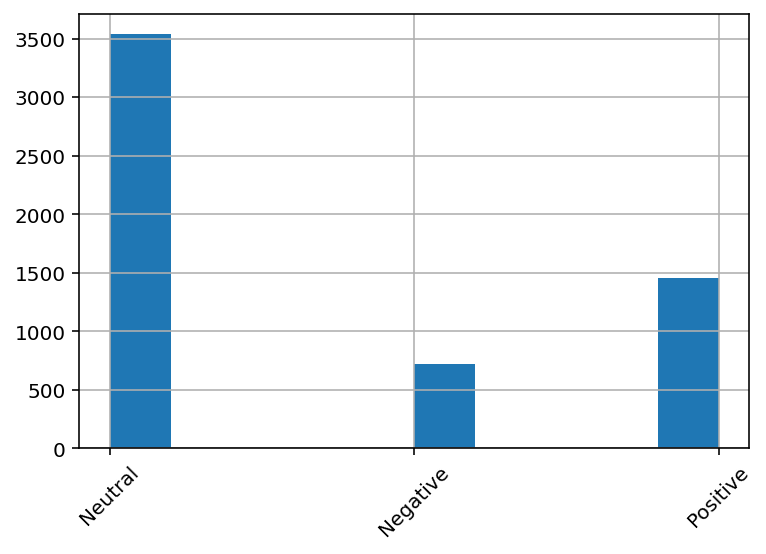

In [8]:
fig,ax = plt.subplots(1,1)

ax.hist(labels)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Neutral','Negative','Positive'],rotation=45)
ax.grid()


To simplify the problem, we're fusing together *Neutral* and *Positive* labels. So label 1 is *Negative review* and label 0 is *Positive+Neutral*. Also, we separate between train, validation and test.

In [9]:
from sklearn.model_selection import train_test_split

labels_bin = labels.copy()

labels_bin[labels_bin==2] = 0 

idx_data = np.arange(0,len(df),1)

# Separamos train de test
idx_train, idx_test, y_train, y_test = train_test_split(idx_data, labels_bin, test_size=0.2, random_state=0)

# Separamos train de val
idx_train, idx_val, y_train, y_val = train_test_split(idx_train, y_train, test_size=0.2, random_state=0)

acc_baseline_train = np.sum(y_train==0)/y_train.shape[0]

### Text pre-processing

With the following code, we pre-process using Spacy each sentence by removing words that are punctuation marks. We also remove [stopping words](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html) (words that are not very informative). As a result, we have the list `norm_docs`. 

In [10]:
nlp = spacy.load("en_core_web_md") # Language model


docs = [nlp(c) for c in phrases]

# We remove punctuation marks (.,;:?!...) and stopping words
def normalize(doc):
    
    return [w for w in doc if w.has_vector and not w.is_punct and not w.is_stop]

norm_docs = [normalize(d) for d in docs]



Every item of `norm_docs` corresponds to each of the sentences in the dataset. Each item is itself a list of spacy tokens (basically words with different attributes). The most important attribute for us the the *word embedding vector*. For instance, lets print the first sentence

In [11]:
print(f'The first original sentence is: {phrases[0]}\n')

print(f'The first normalized sentence is: {norm_docs[0]}. The length of the document is {len(norm_docs[0])} tokens')

The first original sentence is: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .

The first normalized sentence is: [According, Gran, company, plans, production, Russia, company, growing]. The length of the document is 8 tokens


We can access to the word embedding of each token using the attribute `.vector`:

In [12]:
print(f'The word embedding associated with the token {norm_docs[0][0].text} is\n')
print(norm_docs[0][0].vector)

The word embedding associated with the token According is

[-1.8993e-01  7.0686e-03  2.2466e-01  1.1441e-01 -1.7058e-01 -2.0702e-02
  1.0430e-01  6.1981e-02 -5.4537e-02  2.6813e+00 -2.8966e-01  2.2361e-01
 -2.1493e-02  2.9268e-01 -2.5843e-01 -5.3807e-01  3.3709e-01  1.1680e+00
  1.6551e-01  6.5886e-02  1.4446e-01  3.4677e-01 -1.2809e-01 -3.8114e-02
  2.2085e-01  1.9886e-01 -4.1755e-01  1.6474e-01 -2.2054e-01 -2.7242e-02
  8.8179e-02  2.7589e-01  2.5669e-01  2.1639e-01  1.6127e-01  4.2795e-01
  2.0554e-04 -1.3096e-01  5.1889e-02 -1.1941e-01 -2.0728e-01  6.0784e-02
  1.7197e-01 -2.6056e-02 -2.5960e-01 -2.7028e-01  6.9555e-02 -1.3087e-01
  1.0921e-01 -1.2391e-01 -1.8302e-01 -2.8909e-01 -3.3452e-01 -2.5565e-01
 -2.6496e-01 -2.8909e-01 -5.6848e-02  4.3846e-01  1.4577e-01 -2.0472e-01
  3.2083e-01 -5.1273e-02 -1.8690e-01  3.8355e-01 -3.7892e-01  1.7339e-01
 -3.8200e-01  8.3093e-03  2.6051e-01  3.4202e-01 -1.5279e-01 -3.1518e-01
  2.8419e-01 -3.4394e-01 -4.3389e-01  2.5400e-02  5.4666e-02  2.5

You can check that the word embedding dimension is 300 ...

In [13]:
print(f'The WE dimension is {norm_docs[0][0].vector.shape}')

The WE dimension is (300,)


### Length normalization

Note that in this problem we're working with sequences of text of different length. This is in principle not a problem for RNNs. However, there's one additional pre-processing step that we have to do. When we feed the RNN function **all sequences in the mini-batch must have the same length**. Then we will use the corresponding state to make the prediction.

For simplicity, we are taking here a non-efficient solution. Instead of normalize lengths at a batch level, we are normalizing the whole dataset so all sequences have the same length. To do so, we're adding **junk tokens** to all sentences so they artificially are of the same length. However, we will keep in a list the real length of each data, since the sentiment analysis prediction will be made using the RNN state corresponding to the **last real token**.



In [14]:
# List with the length for each sentence

lengths = [len(d) for d in norm_docs]

# Maximum length (in train!)
max_l = np.max([lengths[d] for d in idx_train])

In [15]:
# We add as many junk tokens (#) as needed to equalize the length of each sentence to max_l

garbage_token = nlp('#') # Junk token --> #

# We normalize the dataset

norm_docs_eq_length = [norm_docs[d]+[garbage_token]*(max_l-lengths[d]) for d in range(len(norm_docs))]

# Train documents

docs_train = [norm_docs_eq_length[d] for d in idx_train]

len_train = [lengths[d] for d in idx_train]

# Validation documents

docs_val = [norm_docs_eq_length[d] for d in idx_val]

len_val = [lengths[d] for d in idx_val]

# documentos test

docs_test = [norm_docs_eq_length[d] for d in idx_test]

len_test = [lengths[d] for d in idx_test]

In [16]:
from torch import nn
from torch import optim
import torch

In [342]:
class AttRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,att_size,prob=0.5):
        
        
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
        self.input_size = input_size
        
        # Capa LSTM
        # batch_first=True significa que la primera dimensión del tensor de entrada indexa datos distintos
        self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, dropout=prob, batch_first=True)
        
        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size) 
        
        # Attention layers
        
        self.att1 = nn.Linear(2*hidden_dim,att_size)
        
        self.att2 = nn.Linear(att_size,1)
        
        self.Tanh = nn.Tanh()
        
        self.softmax = nn.Softmax(dim=1)
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=1)
           
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        # Capa dropout 
        
        self.dropout = nn.Dropout(p=prob)

    def forward(self, x, lengths, h0=None):
        
        '''
        
        - x: Sequences of word embeddings. Dimensions (batch_size, max_l, word_embedding_size)
        - lengths: The real length of each sequence, excluding the junk # tokens! You use this to know what
          RNN state you should use to classify

        '''
        
        batch_size = x.size(0) 
        seq_length = x.size(1)
        dim_input = x.size(2)
        
        # Compute the RNN output (sequence of states for the whole input)
        r_out, _ = self.rnn(x, h0) #YOUR CODE HERE
        
        # Lets concatenate the last VALID state to each of the previous states
        
        # Last valid state [batch_size,1,we_size] dimension
        
        aux = torch.stack([r_out[[d],lengths[d]-1,:] for d in range(batch_size)])
        
        # Repeat it seq_length times
        
        aux = aux.repeat(1,seq_length,1)
        
        # Concatenate
        
        extended_r_out = torch.cat([aux,r_out],dim=2)
        
        # Unnormalized attention weights
        
        un_weights = self.att2(self.Tanh(self.att1(extended_r_out.reshape([-1,2*self.hidden_dim])))).reshape([-1,seq_length])
        
        # Mask the weights to eliminate dependency with ###
        
        mask = np.zeros((batch_size,seq_length))
        
        for i in range(batch_size):
            mask[i,(lengths[i]-1):] = -10000.0 ##Very negative value
            
        masked_un_weights = un_weights + torch.Tensor(mask)
        
        # Normalize attention weights and repeat values to match r_out dimensions
        att_weights = self.softmax(masked_un_weights).reshape([-1,seq_length,1]).repeat(1,1,self.hidden_dim)
        
        # Context vector
        context_vector = torch.sum(att_weights * r_out,dim=1)
        
        # Decision
        output = self.logsoftmax(self.fc1(self.dropout(context_vector)))
    
        
        return output,att_weights

In [343]:
my_AttRNN = AttRNN(300,2,20,1,10)

In [344]:
idx = [1,2,3]

#[w.vector for w in docs_train[d]] generates the list of word vectors for the d-th document 
x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx])

In [345]:
print([lengths[d] for d in idx])

[17, 19, 15]


In [346]:
o,att_weights = my_AttRNN.forward(torch.Tensor(x_input),[lengths[d] for d in idx])

print(o.shape)

print(att_weights.shape)

torch.Size([3, 2])
torch.Size([3, 35, 20])


In [347]:
class AttRNN_with_train(AttRNN):
    
    def __init__(self,input_size, output_size, hidden_dim, n_layers,att_size, prob=0.0,batch_size=50,lr=0.0005,saved_files='./saved_models/AttRNN_sentiment_analysis'):
        
        super().__init__(input_size, output_size, hidden_dim, n_layers,att_size, prob)  
        
        self.lr = lr # Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr) # Optimizer
        
        self.criterion = nn.NLLLoss()               
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = [] 
        
        self.batch_size = batch_size
        
        self.saved_files = saved_files
        
        
    def predict_proba(self,docs,lengths,Y=None):
        
        '''
        We use this method to get the output of the network given a set of documents. If label is provided,
        we get accuracy.
        
        - docs: documents, each encoded as a list of spacy tokens. They are length-normalized.
        - lengths: real length of each document.
        - Y: labels
        '''
        accuracy = 0.0
        
        with torch.no_grad(): 
        
            x_input = torch.Tensor([[w.vector for w in d] for d in docs])
        
            logprobs,att_weights = self.forward(x_input,lengths)
            
            logprobs = logprobs.detach().numpy()
            
            att_weights = att_weights.detach().numpy()
            
            if(len(Y)>0):
            
                accuracy = np.sum(np.argmax(logprobs,1)==Y)/np.shape(Y)[0]
            
        return logprobs,accuracy,att_weights
            
        
    def fit(self,docs_train,docs_val,Y,Yval,len_train,len_val,epochs=100,print_every=5):
        
        '''
        Método de entrenamiento.
        
        - docs_train, docs_val: training/validation documents  (each is a list of spacy tokens). 
          Normalized in length!
        - len_train/len_val: real lengths
        '''
        
        self.print_every = print_every
        
        self.epochs=epochs
        
        # Optimization Loop
        
        self.num_train = len(docs_train) # Number of training points
        
        self.num_batchs = np.floor(self.num_train/self.batch_size) # Number of training batches
        
        self.num_val = len(docs_val) # Number of validation points
        
        self.num_batchs_val = np.floor(self.num_val/self.batch_size) # Numero of validation batches
        
        labels = torch.Tensor(Y).type(torch.LongTensor) # Training labels
        
        labelsval = torch.Tensor(Yval).type(torch.LongTensor) # Validation labels
        
        
        for e in range(int(self.epochs)):
            
            self.train() # Activate dropout
            
            # Random data permutation
            
            idx = np.random.permutation(self.num_train)
            
            running_loss = 0.
            
            for i in range(int(self.num_batchs)):
                        
                self.optim.zero_grad()  

                # Indices of the data entering the batch

                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]
                
                # Just in case there are empty documents, we ignore them
                idx_batch = [d for d in idx_batch if len_train[d]>0]
                
                # We code each document using the sequences of word embeddings
                
                x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx_batch])
                
                # We compute the classifier output for every data

                out,_ = self.forward(x_input,[len_train[d] for d in idx_batch])
                
                # Cost function and gradient descent step

                loss = self.criterion(out,labels[idx_batch])
                
                running_loss += loss.item()

                loss.backward()

                # Gradient clipping
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                
                # SGD steps
                
                self.optim.step()
                
            self.loss_during_training.append(running_loss/self.num_batchs)
            
            # We save model parameters
            
            torch.save(self.state_dict(), self.saved_files+'_epoch_'+str(e)+'.pth')
            
            # We repeat for validation
            
            with torch.no_grad(): 
                
                # set model to evaluation mode
                self.eval()
                
                running_loss = 0.
                
                idx = np.random.permutation(self.num_val)

                running_loss = 0.
                
                for i in range(int(self.num_batchs_val)):
                    
                    idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size] 
                    
                    # Just in case there are empty documents, we ignore them
                    idx_batch = [d for d in idx_batch if len_val[d]>0]
                    
                    x_input = torch.Tensor([[w.vector for w in docs_val[d]] for d in idx_batch])

                    out,_  = self.forward(x_input,[len_val[d] for d in idx_batch])

                    loss = self.criterion(out,labelsval[idx_batch])

                    running_loss += loss.item() 
                    
                self.valid_loss_during_training.append(running_loss/self.num_batchs_val)    
                    
                

            if(e % self.print_every == 0): 

                print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}")

In [393]:
my_AttRNN = AttRNN_with_train(input_size=300,output_size=2,hidden_dim=20,att_size=40,prob=0.3,n_layers=1)

#Call train

my_AttRNN.fit(docs_train,docs_val,torch.Tensor(y_train),torch.Tensor(y_val),len_train,len_val,epochs=40,print_every=1)


/Users/olmos/opt/anaconda3/envs/gensim3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Training loss after 0 epochs: 0.5755626759300493. Validation loss: 0.39807849294609493
Training loss after 1 epochs: 0.38373660428883277. Validation loss: 0.32546283221907085
Training loss after 2 epochs: 0.3431124454491759. Validation loss: 0.30319206996096504
Training loss after 3 epochs: 0.31569406716790915. Validation loss: 0.28381118840641445
Training loss after 4 epochs: 0.29379992676924355. Validation loss: 0.26001016630066764
Training loss after 5 epochs: 0.266077970601108. Validation loss: 0.23016138416197565
Training loss after 6 epochs: 0.23389761711228385. Validation loss: 0.20474771368834707
Training loss after 7 epochs: 0.20000821525511675. Validation loss: 0.20059358742502
Training loss after 8 epochs: 0.17952453738001928. Validation loss: 0.17757139768865374
Training loss after 9 epochs: 0.15411820859737593. Validation loss: 0.17718932032585144
Training loss after 10 epochs: 0.13665370393085152. Validation loss: 0.16125279499424827
Training loss after 11 epochs: 0.12165

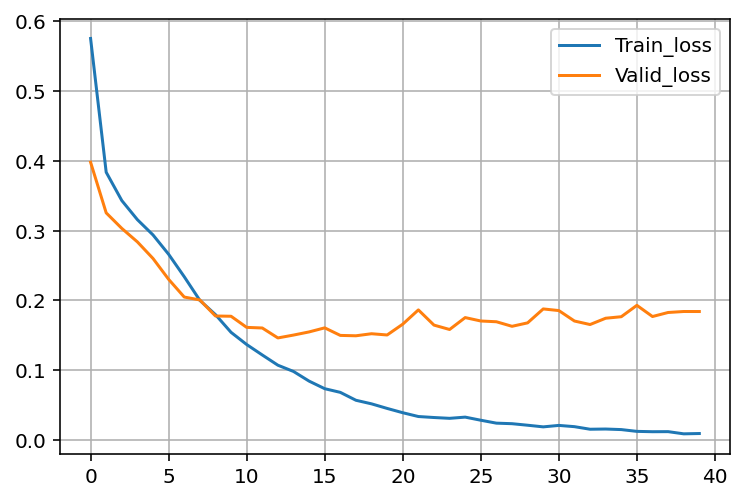

In [394]:
plt.plot(my_AttRNN.loss_during_training,label='Train_loss')
plt.plot(my_AttRNN.valid_loss_during_training,label='Valid_loss')
plt.legend()
plt.grid()

In [395]:
idx_min = np.argsort(my_AttRNN.valid_loss_during_training)

my_AttRNN.load_state_dict(torch.load(my_AttRNN.saved_files+'_epoch_'+str(idx_min[0])+'.pth'))

<All keys matched successfully>

In [396]:
logprobs,acc,att_weights = my_AttRNN.predict_proba(docs_test,len_test,y_test)

probs = np.exp(logprobs)  #YOUR CODE HERE

print(f"The test accuracy is {acc}")

The test accuracy is 0.9396853146853147


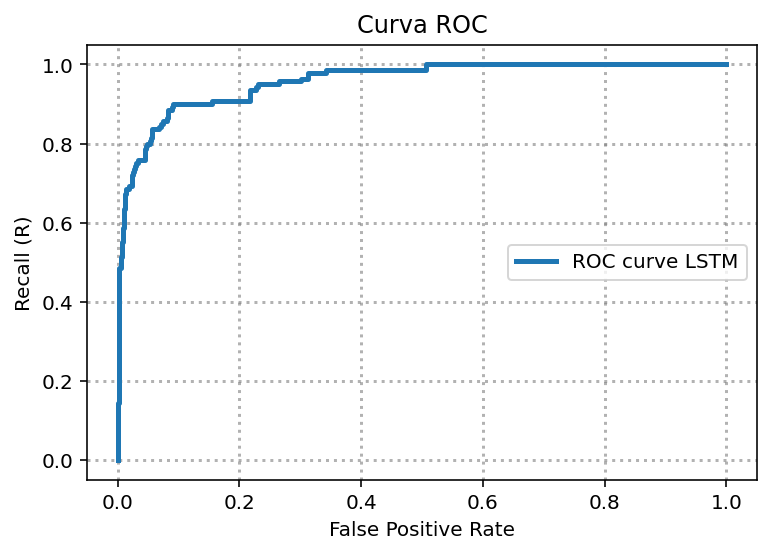

AUC ROC for LSTM is 0.9573847467273762


In [397]:
from sklearn import metrics

fpr, recall, thresholds = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='ROC curve LSTM')
plt.legend(loc=7)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc_LSTM = metrics.roc_auc_score(y_test, probs[:,1])

print(f"AUC ROC for LSTM is {area_roc_LSTM}")

## Visualizing the attention weights

In [398]:
att_weights = att_weights[:,:,0]

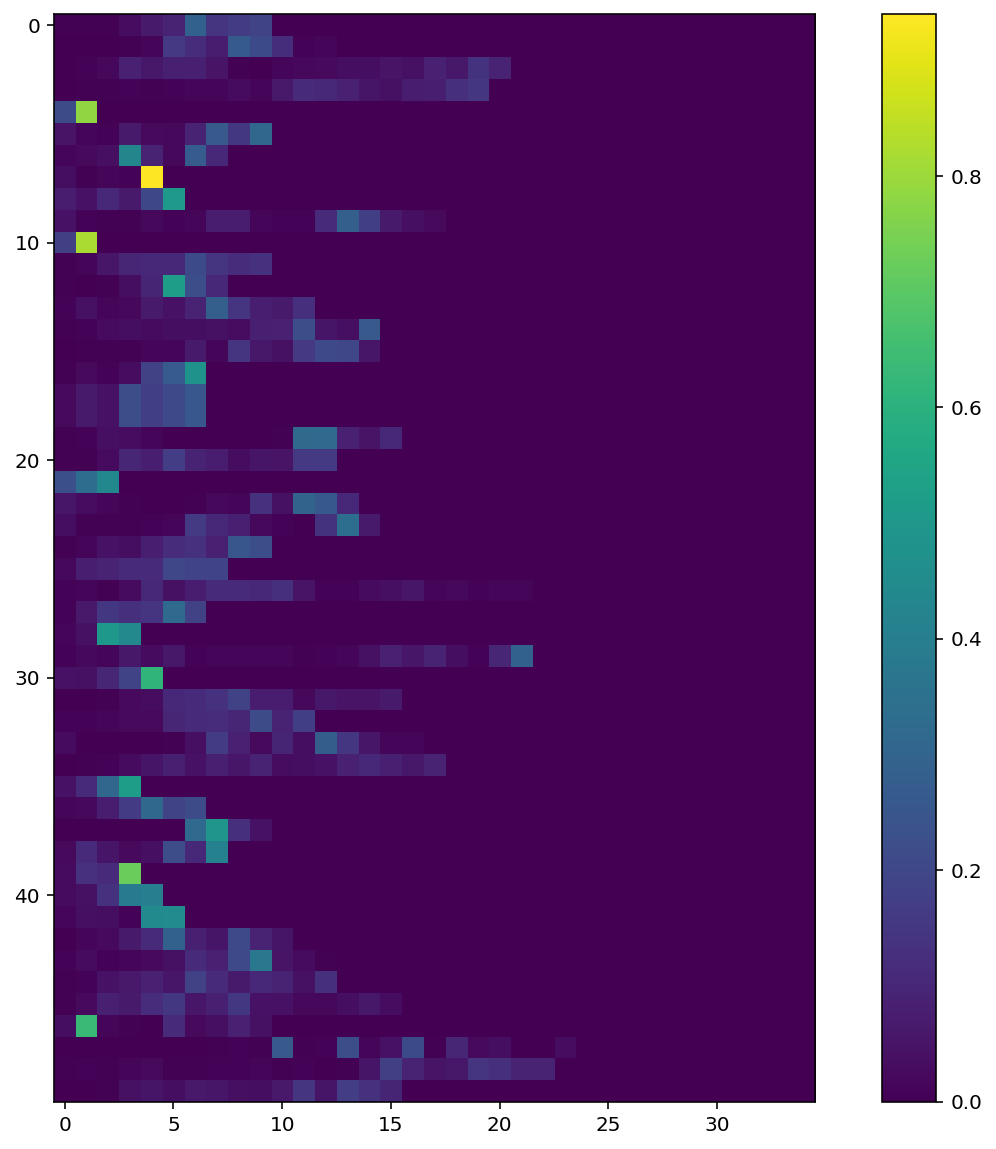

In [399]:
plt.figure(figsize=(12, 10))

plt.imshow(att_weights[:50,:], cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

Lets visualize some particular documents ...

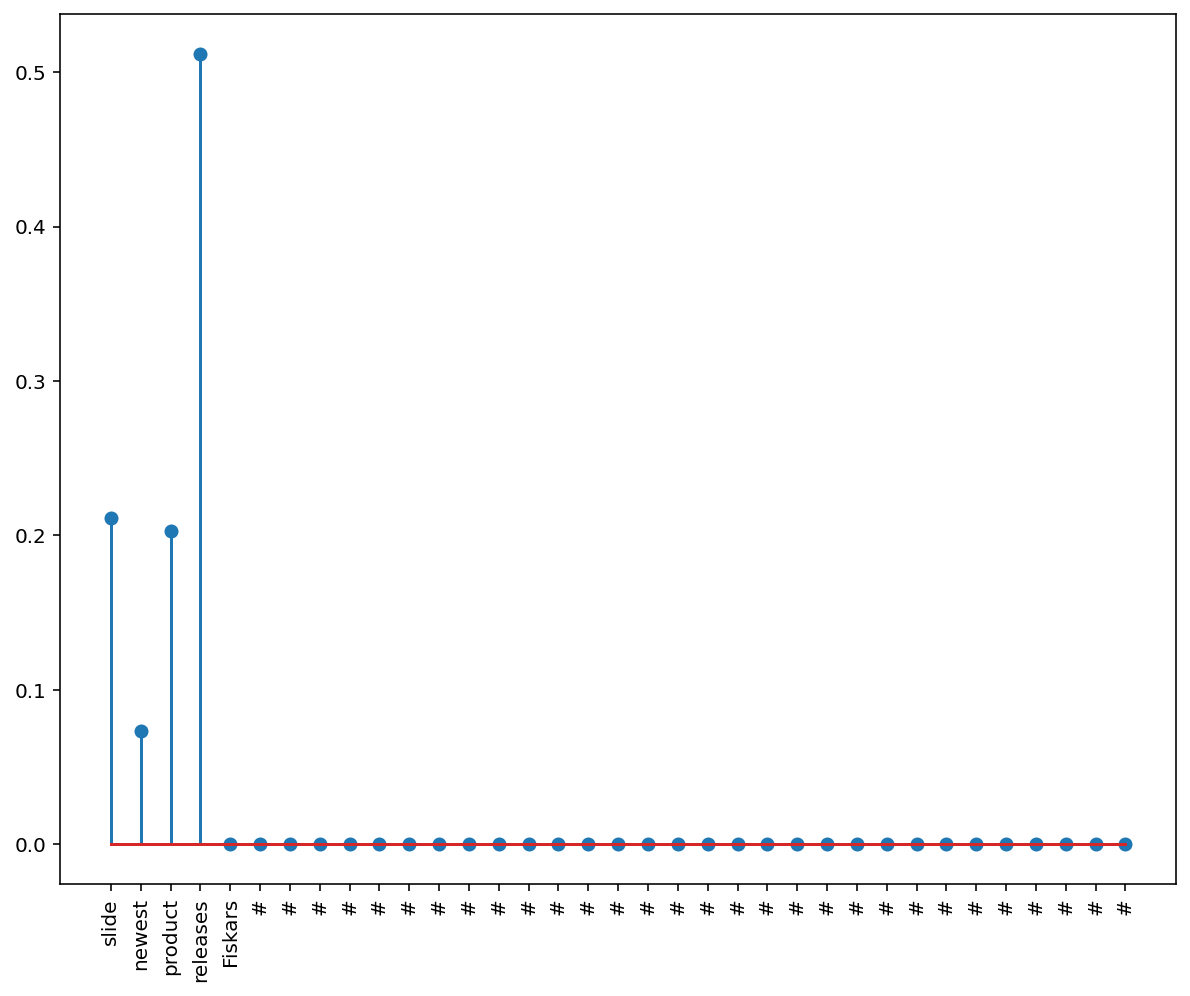

In [406]:
d = 600
fig = plt.figure(figsize=(10, 8))

plt.stem(att_weights[d,:],use_line_collection=True)
plt.xticks(range(max_l), [w.text for w in docs_test[d]],rotation=90)
plt.show()

In [401]:
docs_test[0][0].text

'Sullivan'